In [1]:
%matplotlib inline 
import os
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.optim as optim

/Users/fionachang/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#run our model through gpu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
#build a function to grab dataset from device
def create_dataset(folder, label):
    path = '/Users/fionachang/Desktop/chest_xray'
    path = os.path.join(path, folder, label)
    files_dir = [os.path.join(path, f) for f in os.listdir(path)] #create a list of file pathes for the files in the folder
    imgs = []
    for i in range(len(files_dir)):
        img = mpimg.imread(files_dir[i])
        imgs.append(img)
    return imgs

In [4]:
#six group of data set
chest_train_norm = create_dataset('train','NORMAL')
chest_train_pneu = create_dataset('train','PNEUMONIA')
chest_test_norm = create_dataset('test','NORMAL')
chest_test_pneu = create_dataset('test','PNEUMONIA')
chest_val_norm = create_dataset('val','NORMAL')
chest_val_pneu = create_dataset('val','PNEUMONIA')

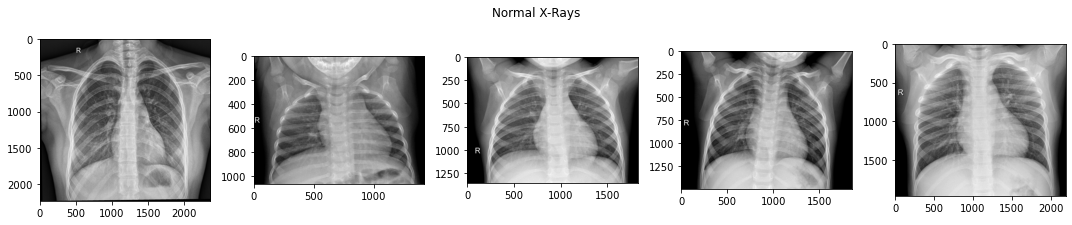

In [5]:
#show the normal images in the training set
fig = plt.figure(figsize=(15, 3))
train_norm_selected = random.sample(chest_train_norm, 5)
for i in range(1,6):
  plt.subplot(1, 5, i)
  plt.imshow(chest_train_norm[i-1], cmap="gray")
fig.suptitle('Normal X-Rays')
plt.tight_layout()

In [6]:
#images are in different sizes

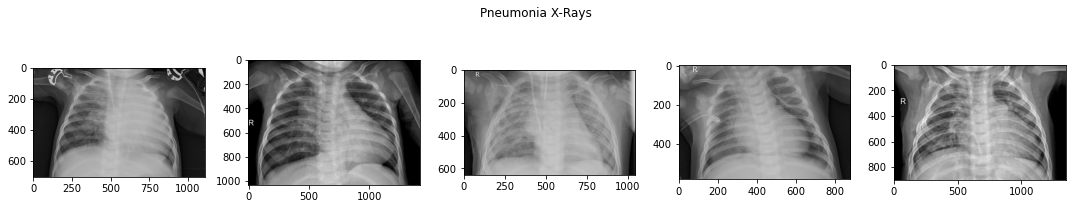

In [7]:
#show the pneumonia images in the training set
fig = plt.figure(figsize=(15, 3))
train_pneu_selected = random.sample(chest_train_pneu, 5)
for i in range(1,6):
  plt.subplot(1, 5, i)
  plt.imshow(train_pneu_selected[i-1], cmap="gray")
fig.suptitle('Pneumonia X-Rays')
plt.tight_layout()

In [8]:
#images are in different sizes

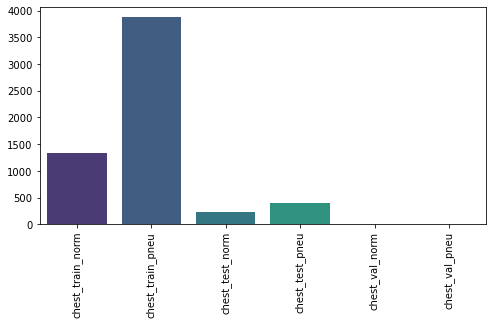

In [9]:
#numbers of images of the six groups
imgs = [chest_train_norm, chest_train_pneu, chest_test_norm, chest_test_pneu, chest_val_norm, chest_val_pneu]
labels = ['chest_train_norm', 'chest_train_pneu', 'chest_test_norm', 'chest_test_pneu', 'chest_val_norm', 'chest_val_pneu']
index = np.arange(6)
lst = [len(x) for x in imgs]
fig = plt.figure(figsize=(8, 4))
sns.barplot(x=index, y=lst, palette="viridis")
plt.xticks(index, labels, rotation='vertical')
plt.show()  

In [10]:
#concatinate training data and validation data together to training data
chest_train_norm = chest_train_norm + chest_val_norm
chest_train_pneu = chest_train_pneu + chest_val_pneu

In [11]:
#concatinate normal data and pneumonia data in training set and testing set
#add labels: 0->normal, 1->pneumonia
train = chest_train_norm + chest_train_pneu
train_labels = [0]*len(chest_train_norm) + [1]*len(chest_train_pneu)

test = chest_test_norm + chest_test_pneu
test_labels = [0]*len(chest_test_norm) + [1]*len(chest_test_pneu)

print(len(train),len(train_labels))
print(len(test),len(test_labels))

5232 5232
624 624


In [12]:
#split training set into training set and validation set
train, val, train_labels, val_labels = train_test_split(
                                                train, train_labels, stratify=train_labels)
print(len(train),len(train_labels))
print(len(val),len(val_labels))

3924 3924
1308 1308


In [13]:
#build a dataset class for pytorch
class ChestXrayDataset(Dataset):
  def __init__(self, imgs, labels, transform=None):
    self.imgs = imgs
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, index):
    img = self.imgs[index]

    if self.transform:
        image = self.transform(img)

    label = self.labels[index]
    label = torch.tensor(label)
    
    return image, label

In [14]:
#build a tranform pipeline for data set
train_transform = T.Compose([
                             T.ToPILImage(), #transform data array to PIL form
                             T.Resize(size = (224,224)), #resize the imgs to the same size
                             T.Grayscale(num_output_channels=3), #return images in three channels r==g==b
                             T.ToTensor(), #transform images to tensor
                             T.RandomRotation(15), #data augmentation
                             T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                             ]) #normalize three tensor channels 
                              

test_transform = T.Compose([
                            T.ToPILImage(), #transform data array to PIL form
                            T.Resize(size = (224,224)), #resize the imgs to the same size
                            T.Grayscale(num_output_channels=3), #return images in three channels r==g==b
                            T.ToTensor(), #transform images to tensor
                            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ]) #normalize three tensor channels 

In [15]:
#transform the data sets to pytorch dataset form
train_dataset = ChestXrayDataset(train, train_labels, train_transform)
val_dataset = ChestXrayDataset(val, val_labels, test_transform)
test_dataset = ChestXrayDataset(test, test_labels, test_transform)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

3924
1308
624


In [16]:
#first five training set labels
train_dataset.labels[0:5]

[1, 1, 1, 1, 0]

In [17]:
#set batch size and run data loader
batch_size = 30
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

#print the number of images in each data set, the size will be the length of data loader 
#times batch size
print("The number of images in a training set is: ", len(train_loader)*batch_size)
print("The number of images in a training set is: ", len(val_loader)*batch_size)
print("The number of images in a training set is: ", len(test_loader)*batch_size)

The number of images in a training set is:  3930
The number of images in a training set is:  1320
The number of images in a training set is:  630


In [18]:
#print the size of each batch 
#[batch size, number of channels, image size, image size]
for images, _ in train_loader:
  print(images.shape)
  break

torch.Size([30, 3, 224, 224])


In [19]:
#CNN model
class CNNNet(nn.Module):   
    def __init__(self):
        super(CNNNet, self).__init__()

        self.cnn_layers = nn.Sequential(
          nn.Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)), #input 3 channels, output 16 channels
          nn.ReLU(inplace=True), #activation function
          nn.MaxPool2d(kernel_size=2, stride=2), #pooling, reduce the features 
          nn.Conv2d(16, 3, kernel_size=(50, 50), stride=(1, 1)), #input 16 channels, output 3 channels
          nn.MaxPool2d(kernel_size=1, stride=1, padding=0, ceil_mode=False) #pooling
        )
    
        self.linear_layers = nn.Sequential(
            nn.Linear(147, 256), #input 147, output 256
            nn.ReLU(), #activation function
            nn.Dropout(0.4), #set 40% of inputs to zero to avoid overfitting
            nn.Linear(256, 2), #input 256, output 2
            nn.LogSoftmax(dim=1) #activation function
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


model = CNNNet()
print(model)

CNNNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 3, kernel_size=(50, 50), stride=(1, 1))
    (4): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=147, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
    (4): LogSoftmax(dim=1)
  )
)


In [20]:
#define learning rate, optimizer, and loss function
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr= learning_rate)
criterion = nn.CrossEntropyLoss()

In [21]:
for epoch in range(15):
    
    correct = 0
    total = 0
    running_loss = 0
    model.train() # indicator for training phase
    for images, labels in train_loader:
    
        optimizer.zero_grad()
        output = model(images)
        
        loss = criterion(output, labels)        
        loss.backward() #backpropagating
        optimizer.step() #optimizes weights
        
        running_loss += loss.item()
        
    else:
        print("Epoch {} - Training loss: {}".format(
            epoch+1, running_loss/len(train_loader)))

Epoch 1 - Training loss: 0.2972103950233405
Epoch 2 - Training loss: 0.16888723789735605
Epoch 3 - Training loss: 0.13870850387420364
Epoch 4 - Training loss: 0.13619134769924268
Epoch 5 - Training loss: 0.12309954331064497
Epoch 6 - Training loss: 0.11655095998084045
Epoch 7 - Training loss: 0.11077566808516173
Epoch 8 - Training loss: 0.10862833746701821
Epoch 9 - Training loss: 0.0999888056668787
Epoch 10 - Training loss: 0.09885283180988813
Epoch 11 - Training loss: 0.09852514326401794
Epoch 12 - Training loss: 0.09886374001085531
Epoch 13 - Training loss: 0.1059728197767648
Epoch 14 - Training loss: 0.09055257390985508
Epoch 15 - Training loss: 0.08249227563985659


In [22]:
#save best parameters on device
filepath = '../chest_xray/cnn_output_train_model.pt'
torch.save(model.state_dict(), filepath)

In [23]:
#run validation set and test accuracy
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 1320 val images: {100 * correct // total} %')

Accuracy of the network on the 1320 val images: 96 %


In [24]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        labels = torch.reshape(labels,(-1,))

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 630 test images: {100 * correct // total} %')

Accuracy of the network on the 630 test images: 79 %
